In [ ]:
%%capture
! pip install -q "tqdm>=4.36.1"

# **Data exploration**
Collection of images were  recorded via remote controlled car: 
[SunFounder Smart Video Car Kit](https://www.sunfounder.com/smart-video-car-kit-v2-0.html). 
<br>
Three features: *steering angle*, *speed*, *visual data*
<br>
#### **Task**: predict <ins>steering angle</ins> and <ins>speed</ins> using visual data

<!-- A dataset of 2000 images was gathered. These were of the car being remotely <br> controlled whilst driving around a test track and through a variety of obstacles <br> designed to replicate real-world autonomous driving challenges.
<img src="https://www.overleaf.com/project/5ea20dae57aac30001c324e3/file/5eb5670d552dce00019b2eee" width="400">  -->
<!-- <br>
Alongside the visual information, the speed and turning angle of the <br>
car recorded. 
<br>
<br>
The two convolutional networks in this notebook are tasked to predict <br>
these two quantities are given the visual information. <br> The output of the networks were restricted to probabilities; two possibilities for the speed [still, moving]
<br> and seventeen for the steering angle.  -->


In [ ]:
import os
import shutil
import random
from tqdm.notebook import tqdm
from collections import Counter

from google.colab import drive
from IPython.display import display
drive.mount('/content/drive')

import warnings 
warnings.filterwarnings("ignore")

import pickle
import numpy as np
import pandas as pd
from matplotlib import rc
from matplotlib import style 
import matplotlib.pyplot as plt
style.use('seaborn-bright')
plt.rcParams['font.family'] = "serif"

ROOT_DIR = '/content/drive/My Drive/Colab Notebooks/MLiS_2_project/data/raw_data'
os.chdir(ROOT_DIR)
driving_scenarios = os.listdir()
%matplotlib inline
results = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Descriptive statistics**

===========Total number of examples: 2584===========


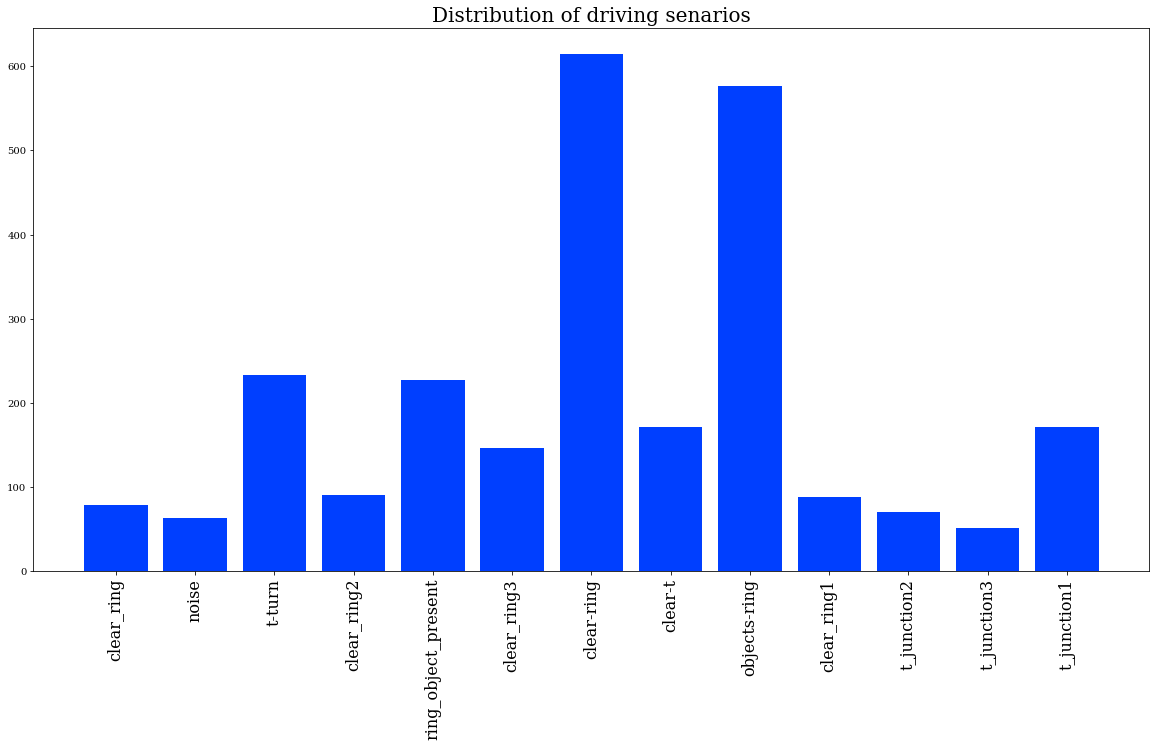

In [ ]:
targets = []
file_names= []
scenarios_count = {}

for scenario in driving_scenarios:
  os.chdir(os.path.join(ROOT_DIR, scenario))
  folder_list = os.listdir()

  scenarios_count[scenario] = len(folder_list)
  target = [name.split('_')[1:] for name in folder_list]
  angle = [name[0] for name in target]
  speed = [name[1].split('.')[0] for name in target]
  target = list(zip(angle,speed))
  target = [(int(angle), int(speed)) for (angle,speed) in target]
  targets = [*targets, *target]
  file_names= [*file_names, *folder_list]
print(f'===========Total number of examples: {len(file_names)}===========')

def distribution_plotting(dictionary_dist, title_string, width, height):
  fig, ax = plt.subplots()
  fig.set_figheight(height)
  fig.set_figwidth(width)
  ax.set_title(f'{title_string}', fontsize=20)
  ax.bar(dictionary_dist.keys(), dictionary_dist.values())
  ax.tick_params(axis='x', labelrotation=90, labelsize=16)

distribution_plotting(scenarios_count, 'Distribution of driving senarios', 20, 10)

assert len(file_names) == len(targets)
  # onlyfiles = [f for f in os.listdir(mypath) if os.isfile(os.join(mypath, f))]

## **Data splitting**
Raw data spread across 13 files &rightarrow; shuffling and splitting into train and test sets.

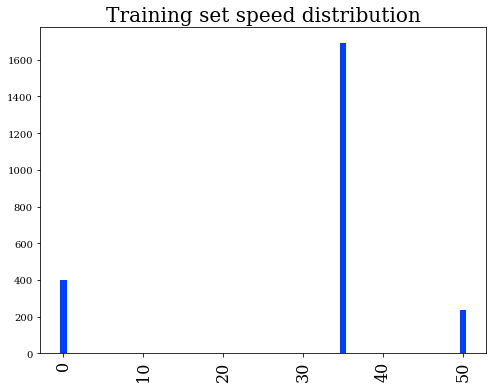

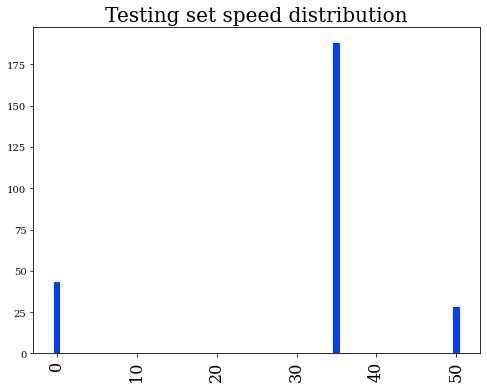

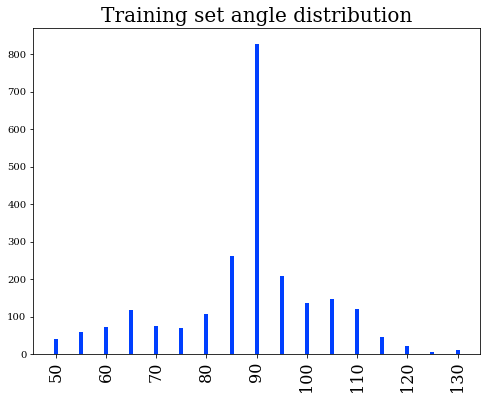

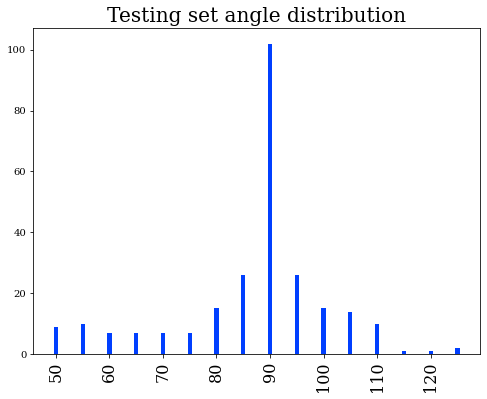

In [ ]:
def find(file_name, root_path):
  '''Checks existence of file in root directory tree ---> checks subfolders for you'''
  for root, dirs, files in os.walk(root_path):
    if file_name in files:
      return os.path.join(root, file_name)

def training_testing_sortation():
  '''Aggregating data from separate folders into test and train folders'''
  for i,example in enumerate(tqdm(train_files, desc='Training data separation...')):
    file_source = find(example,ROOT_DIR)
    file_destination = os.path.join(TRAIN_DIR, f'{i}_'+example[14:])
    shutil.copy2(src=file_source, dst=file_destination)

  for i,example in enumerate(tqdm(test_files, desc='Test data separation...')):
    file_source = find(example, ROOT_DIR)
    file_destination = os.path.join(TEST_DIR, f'{i}_'+example[14:])
    shutil.copy2(src=file_source, dst=file_destination)

def data_testing_training_splitting(file_names, targets):
  '''Splitting data into testing and training set'''
  TRAIN_TEST_SPLIT = 0.90
  dataset = list(zip(file_names, targets))
  random.shuffle(dataset)
  file_names, targets = zip(*dataset)
  train_files, train_targets = file_names[:int(TRAIN_TEST_SPLIT*len(file_names))], targets[:int(TRAIN_TEST_SPLIT*len(targets))]
  test_files, test_targets = file_names[int(TRAIN_TEST_SPLIT*len(file_names)):], targets[int(TRAIN_TEST_SPLIT*len(targets)):]
  return train_files, train_targets, test_files, test_targets 

train_files, train_targets, test_files, test_targets = data_testing_training_splitting(file_names, targets)

print(f'============ Portion of train: {len(train_files)/len(file_names)*100:.2f}% ============\n')
print(f'============ Portion of test: {len(test_files)/len(file_names)*100:.2f}% =============\n') 
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/MLiS_2_project/data/train'
TEST_DIR = '/content/drive/My Drive/Colab Notebooks/MLiS_2_project/data/test'

training_testing_sortation()

train_targets_df = pd.DataFrame(data=train_targets, columns=['Angle', 'Speed'])
test_targets_df = pd.DataFrame(data=test_targets, columns=['Angle', 'Speed'])

print(f'Maximum speed: {max(train_targets_df.Speed.values.tolist())}\n')
print(f'Minimum speed: {min(train_targets_df.Speed.values.tolist())}')

def normalisation(df):
  columns = df.columns
  for column in columns[:2]:
    df['Normalised_'+column] = (df[column]-df[column].mean())/df[column].std()
  return df

def standardisation(df):
  columns = df.columns
  for column in columns[:2]:
    df['Standardised_'+column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())
  return df

standardisation(train_targets_df)
normalisation(train_targets_df)

standardisation(test_targets_df)
normalisation(test_targets_df)

# Plotting training predictor distribution
distribution_plotting(dict(Counter(normalized_train_targets_df.Speed.values.tolist())), 'Training set speed distribution', 8, 6)
distribution_plotting(dict(Counter(normalized_test_targets_df.Speed.values.tolist())), 'Testing set speed distribution', 8, 6)
# Plotting testing predictor distribution
distribution_plotting(dict(Counter(normalized_train_targets_df.Angle.values.tolist())), 'Training set angle distribution', 8, 6)
distribution_plotting(dict(Counter(normalized_test_targets_df.Angle.values.tolist())), 'Testing set angle distribution', 8, 6)

# standardised_train_targets_df
os.chdir(TRAIN_DIR)
with open('training_targets.pickle', 'wb') as file_handle:
  pickle.dump( train_targets_df, file_handle)

os.chdir(TEST_DIR)
with open('testing_targets.pickle', 'wb') as file_handle:
  pickle.dump( test_targets_df, file_handle)


,Angle,Speed,Standardised_Angle,Standardised_Speed,Normalised_Angle,Normalised_Speed
0,115,35,0.8125,0.7,1.831200,0.308301
1,85,35,0.4375,0.7,-0.212583,0.308301
2,95,35,0.5625,0.7,0.468678,0.308301
3,105,0,0.6875,0.0,1.149939,-2.091316
4,90,35,0.5000,0.7,0.128048,0.308301
...,...,...,...,...,...,...
2320,85,35,0.4375,0.7,-0.212583,0.308301
2321,65,35,0.1875,0.7,-1.575105,0.308301
2322,75,35,0.3125,0.7,-0.893844,0.308301
2323,85,35,0.4375,0.7,-0.212583,0.308301


<!-- Gathering dataset. Using panda's _get_dummies_ to convert steering angle and speed <br> into categorical variables. -->

### Note: 
  - **Speed**: <ins>3</ins> possible realisations 
  - **Angle**: <ins>17</ins> possible realisations